In [33]:
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy import units
import astropy.units as u
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.pyplot import axes
import datetime
import matplotlib.dates as mdates
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import rcParams
rcParams['xtick.direction'] = 'out'
rcParams['ytick.direction'] = 'out'

In [2]:
BIGB = SkyCoord(ra=70.66917*u.degree, dec=61.67750*u.degree, frame='icrs')
print BIGB

<SkyCoord (ICRS): (ra, dec) in deg
    ( 70.66917,  61.6775)>


In [3]:
# define MAGIC Location
MAGIC = EarthLocation(lat=28.76194*u.deg, lon=-17.89*u.deg, height=2200*u.m)
utcoffsetSummer = +1*u.hour
utcoffsetWinter = 0*u.hour 


In [4]:
from astropy.coordinates import get_moon
from astropy.coordinates import get_sun

In [113]:
midnight = Time('2016-12-31 00:00:00') + utcoffsetWinter
# create an array of times from 12h before to 12 after midnight
delta_midnight = np.linspace(0,525600,26280)*u.min
times = midnight + delta_midnight
days = np.split(times,365)
print times
print len(days)
print len(days[1])

['2016-12-31 00:00:00.000' '2016-12-31 00:20:00.046'
 '2016-12-31 00:40:00.091' ..., '2017-12-30 23:19:58.909'
 '2017-12-30 23:39:58.954' '2017-12-30 23:59:59.000']
365
72


In [114]:
# MAGIC Horizontal Coordinate system
altazframe = AltAz(obstime=times, location=MAGIC)



In [127]:
# Moon's position in it
moonaltazs = get_moon(times).transform_to(altazframe)


In [118]:

# Sun's position in it
sunaltazs = get_sun(times).transform_to(altazframe)


In [115]:
BIGB_altazs = BIGB.transform_to(altazframe)  

In [129]:
#print days
#print times
print len(times)
print len(BIGB_altazs.alt)
print len(moonaltazs)

26280
26280
26280


In [117]:
year = np.linspace(0,365,365)*u.day
BIGB_spl = np.split(BIGB_altazs,365)
#rint BIGB_altazs.alt
#rint BIGB_altazs.az
print BIGB_spl[1]
print len(BIGB_spl)
print len(BIGB_spl[1])

<SkyCoord (AltAz: obstime=['2017-01-01 00:00:02.288' '2017-01-01 00:20:02.333'
 '2017-01-01 00:40:02.379' '2017-01-01 01:00:02.425'
 '2017-01-01 01:20:02.470' '2017-01-01 01:40:02.516'
 '2017-01-01 02:00:02.562' '2017-01-01 02:20:02.607'
 '2017-01-01 02:40:02.653' '2017-01-01 03:00:02.699'
 '2017-01-01 03:20:02.744' '2017-01-01 03:40:02.790'
 '2017-01-01 04:00:02.836' '2017-01-01 04:20:02.881'
 '2017-01-01 04:40:02.927' '2017-01-01 05:00:02.973'
 '2017-01-01 05:20:03.018' '2017-01-01 05:40:03.064'
 '2017-01-01 06:00:03.110' '2017-01-01 06:20:03.155'
 '2017-01-01 06:40:03.201' '2017-01-01 07:00:03.247'
 '2017-01-01 07:20:03.292' '2017-01-01 07:40:03.338'
 '2017-01-01 08:00:03.384' '2017-01-01 08:20:03.429'
 '2017-01-01 08:40:03.475' '2017-01-01 09:00:03.521'
 '2017-01-01 09:20:03.566' '2017-01-01 09:40:03.612'
 '2017-01-01 10:00:03.658' '2017-01-01 10:20:03.703'
 '2017-01-01 10:40:03.749' '2017-01-01 11:00:03.795'
 '2017-01-01 11:20:03.840' '2017-01-01 11:40:03.886'
 '2017-01-01 12:00:0

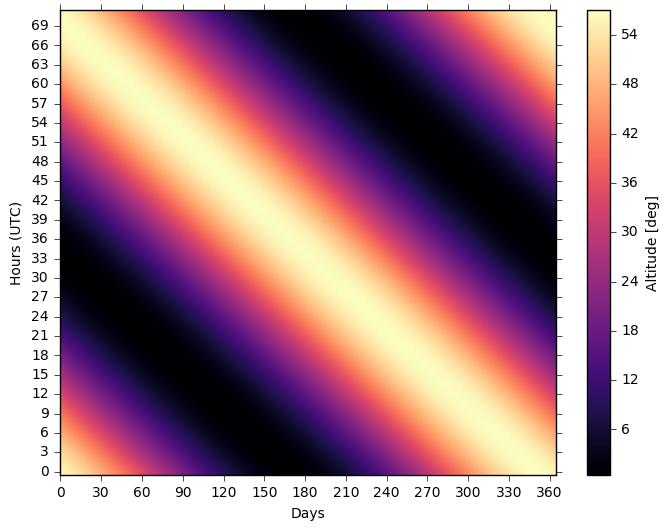

In [119]:
B=np.zeros((72,365))
for i in range(365):
    B[:,i]=BIGB_spl[i].alt

    
fig1 = plt.figure(figsize=(8,6))
    
plt.imshow(B,origin='lower',cmap=cm.magma, aspect='auto')
plt.colorbar().set_label('Altitude [deg]')
plt.xticks(np.arange(0,365,30))
plt.yticks(np.arange(0,72,3))   
plt.xlabel('Days')  
plt.ylabel('Hours (UTC)')
plt.show()

In [123]:
print BIGB_spl[0].alt
print BIGB_altazs.alt
print len(moon_spl[1])

[u'56d16m22.2756s' u'55d24m46.931s' u'54d16m13.4777s' u'52d52m32.7041s'
 u'51d15m43.2412s' u'49d27m43.4655s' u'47d30m26.0306s' u'45d25m34.8339s'
 u'43d14m43.8493s' u'40d59m17.1962s' u'38d40m29.9206s' u'36d19m29.114s'
 u'33d57m15.1293s' u'31d34m42.7593s' u'29d12m42.3067s' u'26d52m00.5164s'
 u'24d33m21.3646s' u'22d17m26.7077s' u'20d04m56.8008s' u'17d56m30.6944s'
 u'15d52m46.5163s' u'13d54m21.6463s' u'12d01m52.7873s' u'10d15m55.935s'
 u'8d37m06.2523s' u'7d05m57.8502s' u'5d43m03.4834s' u'4d28m54.17s'
 u'3d23m58.7506s' u'2d28m43.4052s' u'1d43m31.1539s' u'1d08m41.3669s'
 u'0d44m29.3162s' u'0d31m05.7988s' u'0d28m36.8559s' u'0d37m03.6128s'
 u'0d56m22.2477s' u'1d26m24.0948s' u'2d06m55.8723s' u'2d57m40.0185s'
 u'3d58m15.1117s' u'5d08m16.3444s' u'6d27m16.0224s' u'7d54m44.0586s'
 u'9d30m08.4356s' u'11d12m55.6158s' u'13d02m30.8815s' u'14d58m18.5937s'
 u'16d59m42.3613s' u'19d06m05.1148s' u'21d16m49.0812s' u'23d31m15.6577s'
 u'25d48m45.1786s' u'28d08m36.5714s' u'30d30m06.8951s' u'32d52m30.7515s'
 u'3

In [130]:
moon_spl = np.split(moonaltazs,365)
sun_spl = np.split(sunaltazs,365)

M=np.zeros((72,365))
for i in range(365):
    M[:,i]=moon_spl[i].alt
    
S=np.zeros((72,365))
for i in range(365):
    S[:,i]=sun_spl[i].alt

In [164]:
S1=ma.masked_where(S <= -18, S)
np.putmask(S1, S1>-20, 0)
B1=ma.masked_where(S <= -18, B)


In [148]:
S1=ma.masked_where(S <= 0, S)
np.putmask(S1, S1>-18, 0.2)
np.putmask(S1, S1>-6, 0.1)
np.putmask(S1, S1>0, 0)

In [ ]:
#for i in range(24):
#    for j in range(365):
#        if S[i,j]>0:
#            B[i,j]=0

In [ ]:
print S1[15,180]
print S[15,180]
print B[15,180]

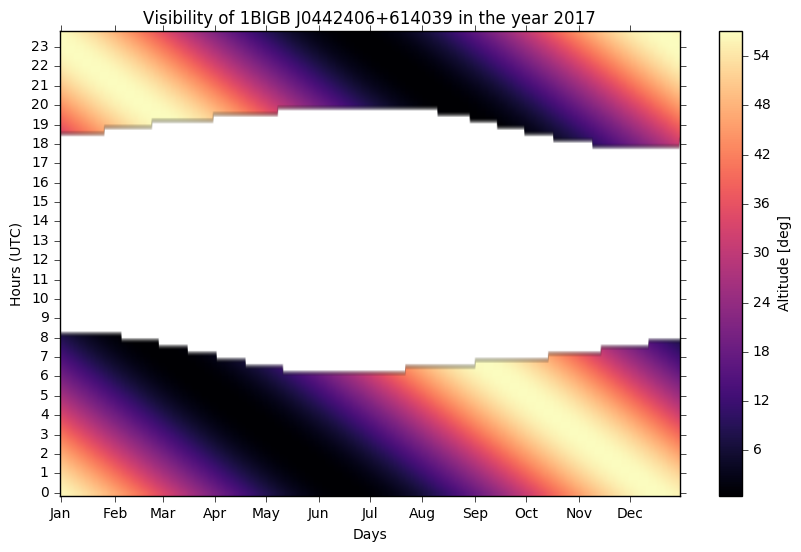

In [163]:
fig2 = plt.figure(figsize=(10,6))

plt.imshow(B,origin='lower',cmap=cm.magma, aspect='auto',zorder=0)
plt.colorbar().set_label('Altitude [deg]')
plt.imshow(S1,origin='lower', cmap=cm.binary, aspect='auto',zorder=1)
#plt.colorbar().set_label('Altitude [deg]')
plt.title("Visibility of 1BIGB J0442406+614039 in the year 2017")
plt.xticks(np.array([0,32,60,91,121,152,182,213,244,274,305,335]),('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'))
plt.yticks(np.arange(0, 72,3),('0','1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23'))   
plt.xlabel('Days')  
plt.ylabel('Hours (UTC)')
plt.show()


In [168]:
print B1.shape

(72, 365)


In [ ]:
h1=0
h2=0
for i in range(72):
    for j in range(365):
        if B1(i,j)>55:
            h1
        elif B1(i,j) in range(40,55)